# Data Preprocessing and Cleaning

This notebook focuses on preparing the dataset for predictive modeling.  

Key tasks include:

1. Handling missing values.
2. Converting data types (already done in EDA, but verify again).
3. Handling outliers or extreme values.
4. Feature scaling / normalization.
5. Encoding categorical variables (if needed).

This clean dataset will be saved and used in the neural network modeling notebook.


In [16]:
import pandas as pd
df = pd.read_csv("water_dataX_explored.csv", encoding='utf-8')

## 1. Handling Missing Values

Some numeric features still contain missing values.  

- Missing values can cause errors or bias in machine learning models.  
- Strategies to handle missing values include:
  1. **Dropping rows or columns** (if too few/many missing values).
  2. **Imputation with mean/median/mode** (common for numeric features).
  3. **Advanced methods** like KNN imputation or regression-based imputation (optional).  

For this project, we will use **median imputation** for numeric features because it is robust to outliers.


In [17]:
# Check missing values

numeric_features = [
    'Temp',
    'D.O. (mg/l)',
    'PH',
    'CONDUCTIVITY (µmhos/cm)',
    'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

df[numeric_features].isnull().sum()

Temp                                 92
D.O. (mg/l)                          31
PH                                    8
CONDUCTIVITY (µmhos/cm)              25
B.O.D. (mg/l)                        43
NITRATENAN N+ NITRITENANN (mg/l)    225
FECAL COLIFORM (MPN/100ml)          316
TOTAL COLIFORM (MPN/100ml)Mean      132
dtype: int64

In [18]:
# Fill missing numeric values using assignment (future-proof)
for feature in numeric_features:
    median_value = df[feature].median()
    df[feature] = df[feature].fillna(median_value)

# Verify
df[numeric_features].isnull().sum()

Temp                                0
D.O. (mg/l)                         0
PH                                  0
CONDUCTIVITY (µmhos/cm)             0
B.O.D. (mg/l)                       0
NITRATENAN N+ NITRITENANN (mg/l)    0
FECAL COLIFORM (MPN/100ml)          0
TOTAL COLIFORM (MPN/100ml)Mean      0
dtype: int64

## 2. Outlier and Skewness Exploration

Before performing any transformations, it is important to:

1. Identify features with extreme outliers.
2. Check the skewness of numeric features.
3. Decide which features might benefit from transformations like log or sqrt.

This ensures that transformations are applied thoughtfully and do not introduce invalid values.


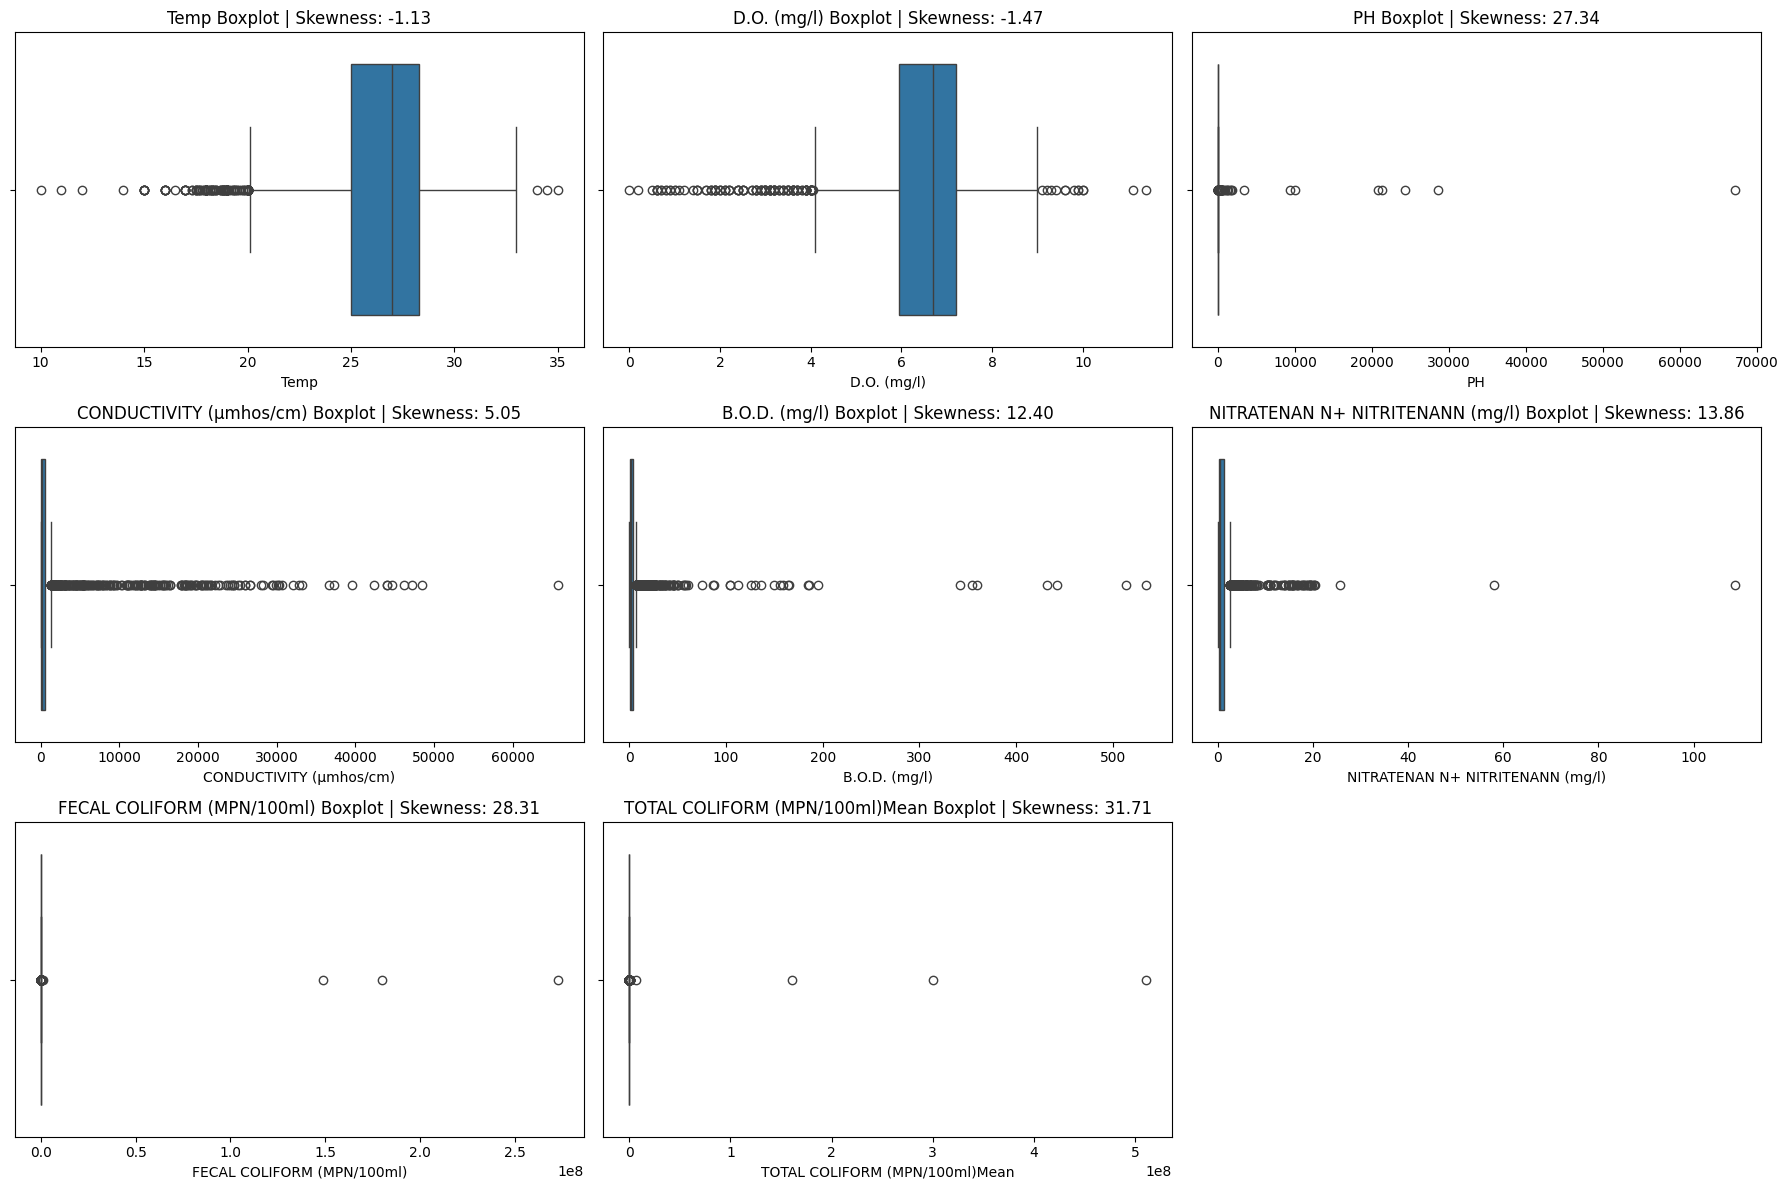

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize boxplots and calculate skewness
plt.figure(figsize=(18,12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df[feature])
    plt.title(f'{feature} Boxplot | Skewness: {df[feature].skew():.2f}')
plt.tight_layout()
plt.show()





In [20]:
# Outlier and skewness summary
summary = pd.DataFrame({
    'Min': df[numeric_features].min(),
    'Max': df[numeric_features].max(),
    'Mean': df[numeric_features].mean(),
    'Median': df[numeric_features].median(),
    'Std': df[numeric_features].std(),
    'Skewness': df[numeric_features].skew()
}).T

summary


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
Min,10.000000,0.000000,0.000000,0.400000,0.100000,0.000000,0.000000e+00,0.000000e+00
Max,35.000000,11.400000,67115.000000,65700.000000,534.500000,108.700000,2.725216e+08,5.110909e+08
Mean,26.246327,6.397422,111.669617,1766.332461,6.831122,1.497969,3.050259e+05,4.983356e+05
Median,27.000000,6.700000,7.300000,183.000000,1.896500,0.516000,2.210000e+02,4.680000e+02
Std,3.291836,1.323062,1875.161891,5520.179564,29.089898,3.868221,8.039897e+06,1.375473e+07
Skewness,-1.126522,-1.468481,27.343852,5.046614,12.397680,13.855750,2.831140e+01,3.171407e+01


### Handling pH Data Errors

- All pH values above 14 are invalid.  
- We replace these extreme values with the **median of valid pH measurements** to correct data errors.


In [21]:
# Identify invalid pH values
invalid_ph = df[df['PH'] > 14]['PH'].count()
print(f"Number of invalid pH values: {invalid_ph}")

# Replace with median of valid pH
median_ph = df[df['PH'] <= 14]['PH'].median()
df.loc[df['PH'] > 14, 'PH'] = median_ph

# Verify
df['PH'].max()


Number of invalid pH values: 89


np.float64(9.01)

## Observation Made Through the Outlier and Skewness Exploration (Do not run this - only for experiment)

The pH scale is defined between 0 and 14.  
Any values outside this range indicate sensor malfunction or data entry errors.
Such records are removed to preserve data integrity before further analysis.

In [22]:
# Check initial dataset size
initial_rows = df.shape[0]

# Remove rows with invalid pH values
df = df[(df['PH'] >= 0) & (df['PH'] <= 14)]

# Check how many rows were removed
final_rows = df.shape[0]
removed_rows = initial_rows - final_rows

initial_rows, final_rows, removed_rows


(1991, 1991, 0)

In [23]:
df['PH'].describe()

count    1991.000000
mean        7.231495
std         0.634196
min         0.000000
25%         6.900000
50%         7.300000
75%         7.600000
max         9.010000
Name: PH, dtype: float64

In [24]:
numeric_cols = [
    'Temp', 'D.O. (mg/l)', 'PH',
    'CONDUCTIVITY (µmhos/cm)', 'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

df[numeric_cols].le(0).sum()

Temp                                 0
D.O. (mg/l)                          1
PH                                   2
CONDUCTIVITY (µmhos/cm)              0
B.O.D. (mg/l)                        0
NITRATENAN N+ NITRITENANN (mg/l)    41
FECAL COLIFORM (MPN/100ml)           4
TOTAL COLIFORM (MPN/100ml)Mean       5
dtype: int64

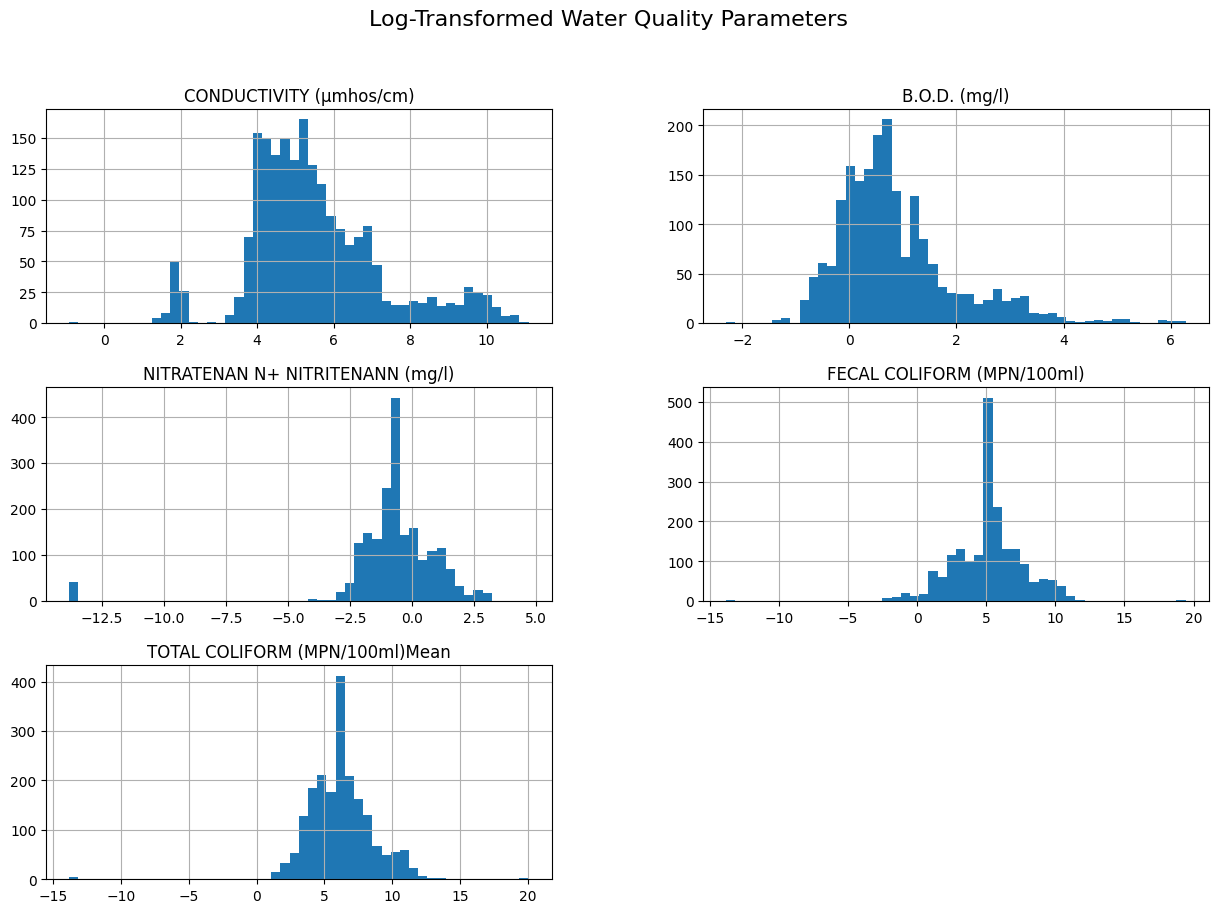

,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,5.313206,0.640010,-2.302585,2.397895,3.295837
1,5.241747,0.693147,-1.609438,8.507749,9.034915
2,5.187386,0.530628,-2.302585,8.084254,8.581107
3,4.158883,1.335001,-0.693147,8.590815,9.041093
4,4.418841,0.641854,-0.916291,8.139732,8.612503


In [18]:
# -------------------------------
# Step 1: Handle zeros and negatives for log-transform
# -------------------------------

import numpy as np

# Small constant to avoid log(0)
epsilon = 1e-6

# List of columns to consider for log-transform
log_cols = [
    'CONDUCTIVITY (µmhos/cm)',
    'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

# Add epsilon to all zero or negative values
for col in log_cols:
    df[col] = df[col].apply(lambda x: x + epsilon if x <= 0 else x)

# -------------------------------
# Step 2: Apply log-transform
# -------------------------------
df[log_cols] = df[log_cols].apply(np.log)

# -------------------------------
# Step 3: Check distributions after transformation
# -------------------------------
import matplotlib.pyplot as plt

df[log_cols].hist(bins=50, figsize=(15,10))
plt.suptitle("Log-Transformed Water Quality Parameters", fontsize=16)
plt.show()

# -------------------------------
# Step 4: Optional verification
# -------------------------------
# Print first few rows to verify transformation
df[log_cols].head()


## Observation

Negative values have been found in Nitratenan which is chemically impossible. So now we have to fix this mistake.
Log-Transformation of Skewed Water Quality Variables
To normalize highly skewed distributions, a natural log transformation was applied to conductivity, BOD, nitrates, and coliform counts. Zeros were replaced with the **minimum positive measurement** for each parameter to avoid negative log values, preserving chemical plausibility. This compresses extreme values while maintaining the relative order of measurements.

In [7]:
df_backup = df.copy()

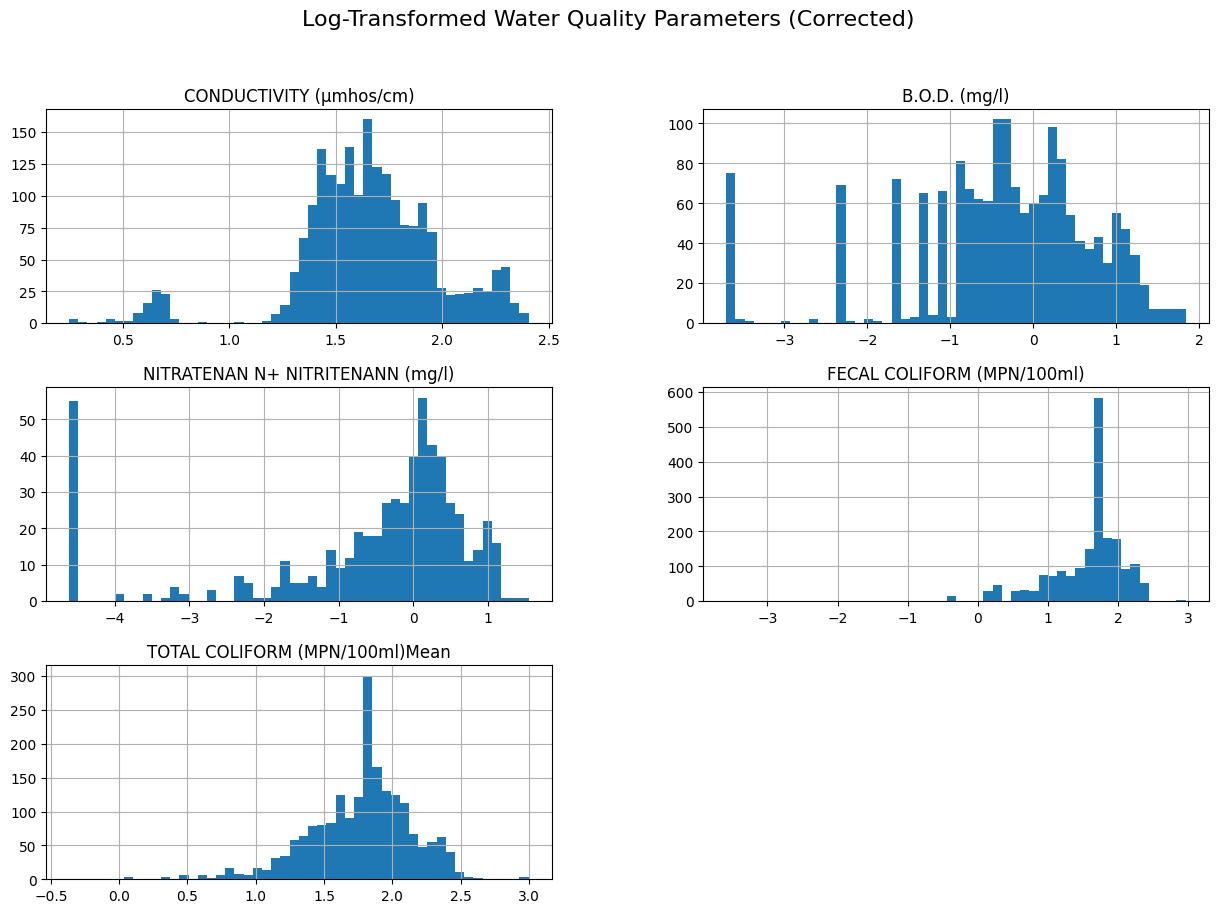

,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,1.670195,-0.446271,NaN,0.874591,1.192660
1,1.656655,-0.366513,NaN,2.140977,2.201097
2,1.646230,-0.633694,NaN,2.089918,2.149563
3,1.425247,0.288932,NaN,2.150694,2.201780
4,1.485877,-0.443395,NaN,2.096757,2.153215


In [20]:
# -------------------------------
# Step 1: Identify numeric columns for transformation
# -------------------------------
numeric_cols = [
    'Temp', 'D.O. (mg/l)', 'PH',
    'CONDUCTIVITY (µmhos/cm)', 'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

# Columns to apply log-transform (highly skewed)
log_cols = [
    'CONDUCTIVITY (µmhos/cm)',
    'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

# -------------------------------
# Step 2: Replace zeros with minimum positive values
# -------------------------------
for col in log_cols:
    min_pos = df[col][df[col] > 0].min()  # minimum positive value
    df[col] = df[col].replace(0, min_pos)

# -------------------------------
# Step 3: Apply log-transform
# -------------------------------
import numpy as np
df[log_cols] = df[log_cols].apply(np.log)

# -------------------------------
# Step 4: Verify transformations
# -------------------------------
import matplotlib.pyplot as plt

df[log_cols].hist(bins=50, figsize=(15,10))
plt.suptitle("Log-Transformed Water Quality Parameters (Corrected)", fontsize=16)
plt.show()

# Check first few rows
df[log_cols].head()

In [25]:
# Number of rows and columns after pH filtering
df.shape
df.head(10)


,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.8965,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0000,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7000,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8000,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9000,0.4,3428.0,5500.0,2014
5,1400,"MANDOVI AT NEGHBOURHOOD OF PANAJI, GOA",GOA,30.0,5.5,7.4,81.0,1.5000,0.1,2853.0,4049.0,2014
6,1476,"MANDOVI AT TONCA, MARCELA, GOA",GOA,29.2,6.1,6.7,308.0,1.4000,0.3,3355.0,5672.0,2014
7,3185,RIVER MANDOVI AT AMONA BRIDGE,GOA,29.6,6.4,6.7,414.0,1.0000,0.2,6073.0,9423.0,2014
8,3186,RIVER MANDOVI AT IFFI JETTY,GOA,30.0,6.4,7.6,305.0,2.2000,0.1,3478.0,4990.0,2014
9,3187,RIVER MANDOVI NEAR HOTEL MARRIOT,GOA,30.1,6.3,7.6,77.0,2.3000,0.1,2606.0,4301.0,2014


## 3. Feature Scaling and Normalisation

Following exploratory data analysis and initial data cleaning, the dataset was prepared for modelling by applying feature scaling. Scaling is a crucial preprocessing step for machine learning algorithms, particularly those that rely on distance-based calculations or gradient-based optimisation, such as neural networks.

The water quality dataset contains variables measured in vastly different units and ranges. For example, temperature values range between tens of degrees, while microbial counts (e.g., coliforms) can reach values in the order of hundreds of millions. Without scaling, features with larger numeric ranges would dominate the learning process and bias model performance.

Two commonly used scaling techniques were considered: Standard Scaling and Robust Scaling.

StandardScaler standardises features by removing the mean and scaling to unit variance. However, this method is highly sensitive to extreme values and assumes an approximately normal distribution.

RobustScaler, on the other hand, scales features using the median and interquartile range (IQR), making it significantly less sensitive to outliers.

Given that the dataset contains extreme but meaningful values (e.g., pollution spikes caused by industrial discharge or sewage contamination), removing or suppressing these values would result in a loss of important environmental information. Therefore, RobustScaler was selected to preserve the influence of extreme events while ensuring numerical stability for downstream models.

Only numerical water quality parameters were scaled. No logarithmic or power transformations were applied, as such transformations can produce negative or undefined values for variables with zeros or small magnitudes and may violate physical or chemical interpretability.

The scaling was applied as follows:

Raw features were preserved in the original dataset.

Scaled features were stored in a separate dataset to avoid irreversible transformations.

The median and IQR of each feature were used to compute scaled values.

This approach ensures reproducibility, interpretability, and flexibility for future modelling stages.

In [26]:
from sklearn.preprocessing import RobustScaler

features = [
    'Temp',
    'D.O. (mg/l)',
    'PH',
    'CONDUCTIVITY (µmhos/cm)',
    'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

scaler = RobustScaler()

df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])


In [27]:
df.shape


(1991, 12)

In [28]:
df.head(10)

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.8965,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0000,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7000,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8000,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9000,0.4,3428.0,5500.0,2014
5,1400,"MANDOVI AT NEGHBOURHOOD OF PANAJI, GOA",GOA,30.0,5.5,7.4,81.0,1.5000,0.1,2853.0,4049.0,2014
6,1476,"MANDOVI AT TONCA, MARCELA, GOA",GOA,29.2,6.1,6.7,308.0,1.4000,0.3,3355.0,5672.0,2014
7,3185,RIVER MANDOVI AT AMONA BRIDGE,GOA,29.6,6.4,6.7,414.0,1.0000,0.2,6073.0,9423.0,2014
8,3186,RIVER MANDOVI AT IFFI JETTY,GOA,30.0,6.4,7.6,305.0,2.2000,0.1,3478.0,4990.0,2014
9,3187,RIVER MANDOVI NEAR HOTEL MARRIOT,GOA,30.1,6.3,7.6,77.0,2.3000,0.1,2606.0,4301.0,2014


In [29]:
numeric_cols = [
    'Temp', 'D.O. (mg/l)', 'PH',
    'CONDUCTIVITY (µmhos/cm)', 'B.O.D. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'FECAL COLIFORM (MPN/100ml)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]


In [30]:
df_scaled[numeric_cols].head(10)


,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,1.090909,0.00,0.285714,0.040858,0.000000,-0.452174,-0.358056,-0.279379
1,0.848485,-0.80,-0.142857,0.012257,0.043125,-0.343478,8.068201,5.019322
2,0.757576,-0.32,-0.571429,-0.008172,-0.081875,-0.452174,5.152600,3.080139
3,0.818182,-0.72,-0.571429,-0.243105,0.793125,-0.017391,8.799659,5.052265
4,0.757576,-0.72,0.000000,-0.204290,0.001458,-0.126087,5.468031,3.187837
5,0.909091,-0.96,0.142857,-0.208376,-0.165208,-0.452174,4.487639,2.268609
6,0.666667,-0.48,-0.857143,0.255363,-0.206875,-0.234783,5.343564,3.296801
7,0.787879,-0.24,-0.857143,0.471910,-0.373542,-0.343478,9.977835,5.673107
8,0.909091,-0.24,0.428571,0.249234,0.126458,-0.452174,5.553282,2.864745
9,0.939394,-0.32,0.428571,-0.216547,0.168125,-0.452174,4.066496,2.428255


In [31]:
df.to_csv("water_dataX_cleaned.csv", index=False, encoding="utf-8")


In [32]:
df_scaled.to_csv("water_dataX_scaled.csv", index=False, encoding='utf-8')